In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
a = pd.read_csv('data/2pmj-y4p4.tsv', sep='\t')
a = a.round(1)


b = pd.read_csv('data/3nja-bsch.tsv', sep='\t')
b = b.round(1)


c = pd.read_csv('data/avir-tzek.tsv', sep='\t')
d = c.round(1)


d = pd.read_csv('data/h3zm-ta5h.tsv', sep='\t')
d = d.round(1)


e = pd.read_csv('data/m59i-mqex.tsv', sep='\t')
e = e.round(1)


In [27]:
#aa = a.copy()
#aa.fillna(aa.median(numeric_only=True, skipna=True), inplace=True)
#aa.fillna(aa.mode().iloc[0], inplace=True)

bb = b.copy()
bb.fillna(bb.median(numeric_only=True, skipna=True), inplace=True)
bb.fillna(bb.mode().iloc[0], inplace=True)

cc = c.copy()
cc.fillna(cc.median(numeric_only=True, skipna=True), inplace=True)
cc.fillna(cc.mode().iloc[0], inplace=True)

dd = d.copy()
dd.fillna(dd.median(numeric_only=True, skipna=True), inplace=True)
dd.fillna(dd.mode().iloc[0], inplace=True)

ee = e.copy()
ee.fillna(ee.median(numeric_only=True, skipna=True), inplace=True)
ee.fillna(ee.mode().iloc[0], inplace=True)

In [12]:
b['circulation_young_adult'].dropna()

0      20149.0
1      39402.0
2      16783.0
3      14352.0
4      26945.0
5      30858.0
6      21545.0
7      37962.0
8      14443.0
9      25338.0
10     10710.0
11     27844.0
12      6743.0
13     34916.0
14     31002.0
15     30736.0
16       165.0
17     14765.0
18     16372.0
19    421030.0
21     33683.0
22     28170.0
23     82349.0
24     21736.0
25     14699.0
26     27269.0
27     44891.0
28     25640.0
29     10853.0
30     24474.0
31     13994.0
32     29360.0
33     34573.0
34     43961.0
35     15903.0
36      8938.0
37     82085.0
38     19902.0
39    562480.0
40         0.0
41         0.0
42    983510.0
Name: circulation_young_adult, dtype: float64

In [33]:
def getCounts(labels):
    labels.dropna(inplace = True)
    values, counts = np.unique(labels, return_counts=True)
    
    d = {}
    for v, c in zip(values, counts):
        d[v] = c
    return d

def calcEntropy(labels):
    counts_raw = np.array(list(labels.values())) 
    if counts_raw.shape[0] == 1:
        return 0
    counts = counts_raw[counts_raw.nonzero()]
    
    probs = counts/counts.sum() #get probs of feature
    
    label_entropy = -np.sum(probs * np.log(probs)) #calculate entropy
    entropy_weight = 2*(1 - 1/(1 + np.exp(-label_entropy)))
    
    return  entropy_weight * label_entropy

def adjustEntropy(data, dicts):
    entropy_row = np.zeros(len(dicts))
    for pos, key  in enumerate(data): #find value to remove in each feature
        if pd.isnull(key):
            entropy_row[pos] = calcEntropy(dicts[pos])
        else:
            dicts[pos][key] -= 1
            entropy_row[pos] = calcEntropy(dicts[pos])
            dicts[pos][key] += 1
    return entropy_row

def GreedyWeightedEntropy(data):
    
    d1 = [getCounts(data[col]) for col in data.columns] #get feature dicts
    tot_e = np.sum([calcEntropy(d) for d in d1]) #calc initial weighted-entropy
    o_factors = np.array([tot_e for x in range(data.shape[0])])
    for i in data.index: 
        
        adjusted = adjustEntropy(data.iloc[i], d1).sum()
        o_factors[i] -= adjusted
            
    return np.where(o_factors > 0)[0], o_factors
    

Percentage of Outliers: 54.18478260869565
Percentage of Outliers: 4.651162790697675
Percentage of Outliers: 0.0
Percentage of Outliers: 28.97959183673469
Percentage of Outliers: 33.86454183266932


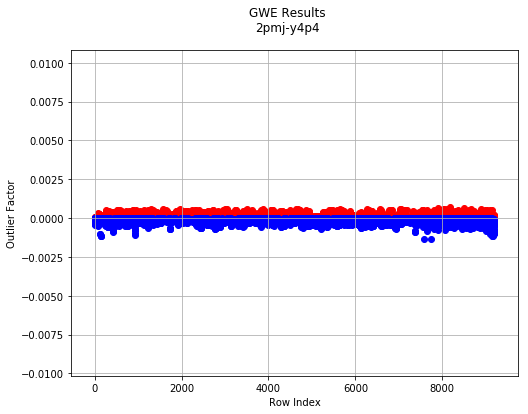

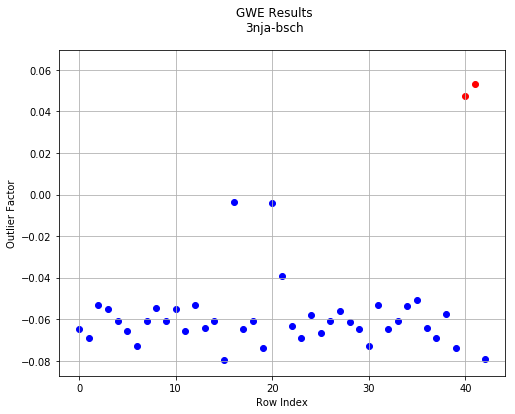

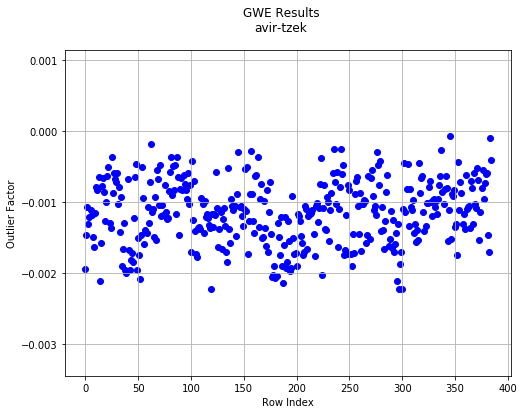

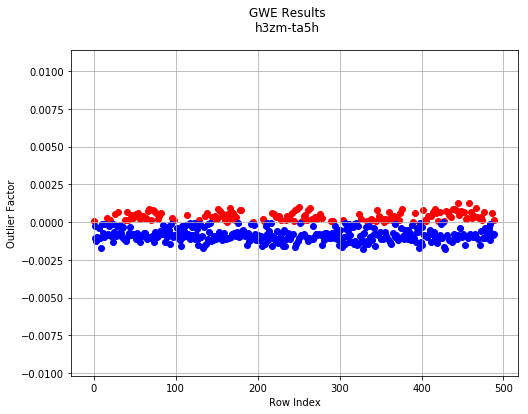

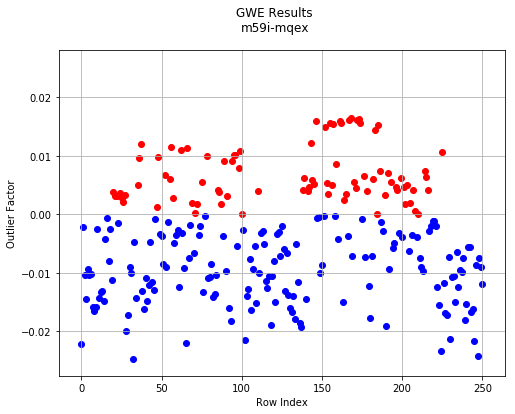

In [36]:
for data in [(a,'2pmj-y4p4'),(b,'3nja-bsch'),(c,'avir-tzek'),(d,'h3zm-ta5h'),(e,'m59i-mqex')]:
    outliers, factors = GreedyWeightedEntropy(data[0])
    print('Percentage of Outliers: {}'.format(outliers.shape[0]/data[0].shape[0] * 100))
    fig = plt.figure(figsize=(8,6))
    
    factors_pos = factors.copy()
    factors_neg = factors.copy()

    factors_pos[factors_pos <= 0] = np.nan
    factors_neg[factors_neg > 0] = np.nan
    
    
    plt.scatter(data[0].index, factors_pos, color='r')
    plt.scatter(data[0].index, factors_neg, color='b')
    plt.grid()
    plt.xlabel('Row Index')
    plt.ylabel('Outlier Factor')
    plt.suptitle('GWE Results\n{}'.format(data[1]))
    fig.savefig('images/{}.png'.format(data[1]), bbox_inches='tight')